In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1" 

import numpy as np
import pandas as pd
import sys
import re
import concurrent.futures
import tqdm
import multiprocessing
from functools import partial
import pickle

sys.path.append('/shareb/zliu/analysis/')
sys.path.append('/shareb/zliu/analysis/CHARMtools')
from CHARMtools import Cell3Ddev as Cell3D
from CHARMtools import MultiCell3D
from CHARMtools import spatialstat

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats


plt.rcParams['pdf.use14corefonts'] = True
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['axes.grid'] = False
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact

import pybedtools

/tmp/ipykernel_564040/3613112242.py:32: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [2]:
h3k4me3_peak = pd.read_csv("../data/publicdata/ENCODE/ENCFF406BED_encode_mESCE14_H3K4me3.bed.gz",sep="\t",header=None).iloc[:,0:3]
h3k4me3_peak.columns = ["chrom","start","end"]
h3k27me3_peak_bruce4 = pd.read_csv("../data/publicdata/ENCODE/ENCFF008XKX_encode_mESCBruce4_H3K27me3.bed.gz",sep="\t",header=None).iloc[:,0:3]
h3k27me3_peak_bruce4.columns = ["chrom","start","end"]
h3k27me3_peak_bruce4["start"] = h3k27me3_peak_bruce4["start"] - 2000
h3k27me3_peak_bruce4["end"] = h3k27me3_peak_bruce4["end"] + 2000

chrom_length = pd.read_csv("/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.len",sep="\t",header=None)
chrom_length.columns = ["chrom","length"]

h3k4me3_bed = pybedtools.BedTool.from_dataframe(h3k4me3_peak)
h3k27me3_bed = pybedtools.BedTool.from_dataframe(h3k27me3_peak_bruce4)
bivalent_peaks = h3k4me3_bed.intersect(h3k27me3_bed,wa=True).to_dataframe().drop_duplicates()
bivalent_peaks.columns = ["chrom","start","end"]

In [3]:
# 5kb bins
bins_table = pd.read_table("/share/Data/public/ref_genome/mouse_ref/M23/CpG/normal_cpg/M23.CpG.5000.txt",header=None).iloc[:,0:3]
bins_table = bins_table.rename(columns={0:"chrom",1:"start",2:"end"})

In [4]:
bins_table

,chrom,start,end
0,chr1,3000000,3005000
1,chr1,3005000,3010000
2,chr1,3010000,3015000
3,chr1,3015000,3020000
4,chr1,3020000,3025000
...,...,...,...
530779,JH584304.1,90000,95000
530780,JH584304.1,95000,100000
530781,JH584304.1,100000,105000
530782,JH584304.1,105000,110000


In [5]:
bivalent_bins = pybedtools.BedTool.from_dataframe(bins_table).intersect(h3k4me3_bed.intersect(h3k27me3_bed,wa=True),wa=True).to_dataframe().drop_duplicates()
bivalent_bins.reset_index(drop=True,inplace=True)

***** WARNING: File /tmp/pybedtools.00g47nv6.tmp has inconsistent naming convention for record:
GL456210.1	0	5000

***** WARNING: File /tmp/pybedtools.00g47nv6.tmp has inconsistent naming convention for record:
GL456210.1	0	5000



In [6]:
bivalent_bins.to_csv("bivalent_bins.bed",sep="\t",header=False,index=False)

In [7]:
metadata=pd.read_csv("../data/metadata/metadata.tsv",sep="\t")
cellnames = metadata["cellname"].values

In [8]:
def _load_cell(cellname, resolution):
    cell = Cell3D.Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"../data/tdg/{cellname}.5k.3dg.gz",
    )
    cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz",
                     column_name="atac" ,keep_3prime=True,type="allelic_resolved")
    cell.add_bed_data(path=f"../data/fragments/ct_frags/{cellname}.ct.frag.bed.gz", 
                     column_name="ct" ,keep_3prime=True,type="allelic_resolved")
    cell.add_bed_data(path=f"./bivalent_bins.bed", 
                     column_name="bivalent_bins" ,keep_3prime=False,type="all")      
    cell.subset(query="bivalent_bins > 0", in_place=True)
    return cell

with concurrent.futures.ProcessPoolExecutor(max_workers=50) as executor:
    cells = list(tqdm.tqdm(executor.map(_load_cell, metadata['cellname'], [5000]*len(metadata)), total=len(metadata)))

100%|██████████| 805/805 [02:40<00:00,  5.03it/s]


In [9]:
def _process_cell(cell):
    """
    group points by if atac > 0 and if ct > 0 ,return odds ratio
    """
    temp_df = cell.get_data().copy()
    temp_df["if_atac"] = temp_df["atac"].apply(lambda x: 1 if x > 0 else 0)
    temp_df["if_ct"] = temp_df["ct"].apply(lambda x: 1 if x > 0 else 0)

    temp_df = temp_df.groupby(["if_atac","if_ct"]).agg({"bivalent_bins":"count"}).reset_index(inplace=False)
    temp_df = temp_df.sort_values(by=["if_atac","if_ct"],ascending=[False,False])
    #print(temp_df[["bivalent_bins"]].values.reshape(2,2))
    odds_ratio, p_value = fisher_exact(temp_df[["bivalent_bins"]].values.reshape(2,2))
    return odds_ratio, p_value

odds_ratios = []
p_values = []
with concurrent.futures.ProcessPoolExecutor(max_workers=50) as executor:
    results = list(tqdm.tqdm(executor.map(_process_cell, cells), total=len(cells)))
    for odds_ratio, p_value in results:
        odds_ratios.append(odds_ratio)
        p_values.append(p_value)

100%|██████████| 805/805 [00:02<00:00, 292.88it/s]


In [10]:
#np.array(odds_ratios)
stats.wilcoxon(np.array(odds_ratios)-1)

WilcoxonResult(statistic=81.0, pvalue=2.869684338936139e-133)

median: 1.592928341185222


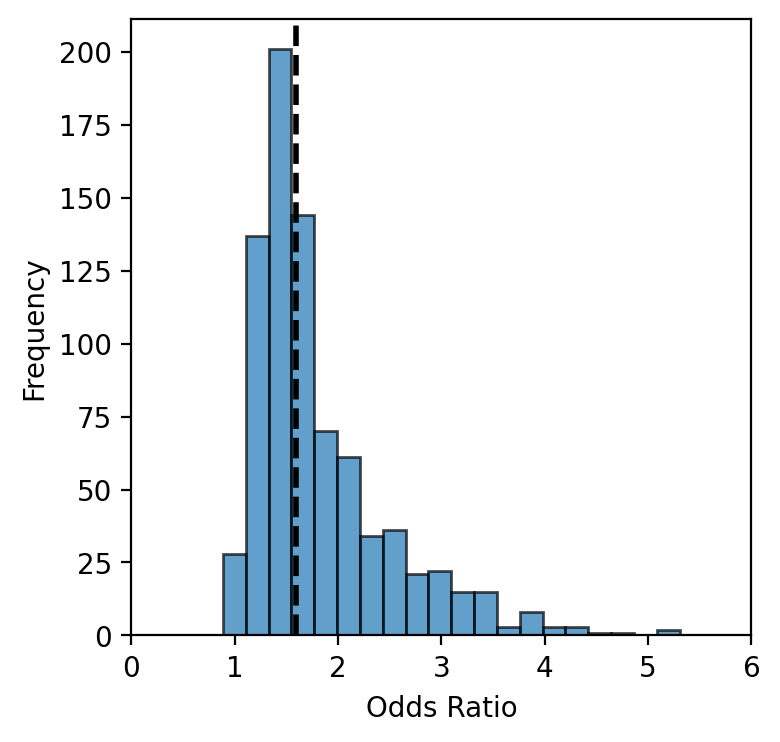

In [14]:
plt.figure(figsize=(4, 4))
#plt.hist(np.log2(np.array(odds_ratios)+1))
plt.hist(np.array(odds_ratios), bins=20, edgecolor='black', alpha=0.7)
# median line 
median = np.median(np.array(odds_ratios))
plt.axvline(median, color='black', linestyle='dashed', linewidth=2)
print(f"median: {median}")
plt.xlim(0, 6)
plt.xlabel("Odds Ratio")
plt.ylabel("Frequency")
plt.savefig("figures/odds_ratio_hist.pdf", bbox_inches='tight')